# Summary:

#### In this notebook, the optimal network configurations obtained from the runs in the preceding notebook ('02_Freddie_Freeloader.ipynb') are applied to the clean data set with added random noise. The noise is added in two different ways: 
#### 1) 'Add distortion': The noise is fed as separate input to the model while the target variable remains the clean time series
#### 2) 'Distort signal': The noise is added ontop of the clean time series data, which is taken as the target variable.
#### In both scenarios, the model performance is measures as a function of the magnitude of the level of noise.

#### The best performing model configuration will be used in the notebook '04_All_Blues.ipynb' to fine tune the amount of historical information to be fed into the model in order to minimize the forecasting error.

# Table of contents
* [1. Load modules](#Part1_link)
* [2. Distortion next to clean time series](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Evaluate model performance under varying noise levels](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Visualize and save results](#Part2.2_link)
* [3. Distorted time series](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Evaluate model performance under varying noise levels](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Visualize and save results](#Part3.2_link)

<a id='Part1_link'></a>
# 1. Load modules

In [1]:
import sys
sys.path.append("../src/")
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd


<a id='Part2_link'></a>
# 2. Distortion next to clean time series

Run RNN and LSTM model with noise as a separate feature. Evaluate model performance for a range of magnitudes in the level of the noise.

In [2]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=5*364, freq='d')

# take a sine function as the observations
num_periods = 10  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]

# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# set target feature 
mdq._selected_features = ['observations']

# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)
past_history_size = int(1*365)

# specify model configuration: this is chosen basen on the results from the previous notebook 02_Freddie_Freeloader.ipynb
units = 128  # number of units in each neural network layer
num_layers = 2  # total number of layers
epochs = 10


<a id='Part2.1_link'></a>
### 2.1 Evaluate model performance under varying noise levels

The following steps are repeated from the previous notebook, '02_Freddie_Freeloader.ipynb', and are grouped into one single step here for simplicity.

training set shape: x:(909, 365, 1), y:(909, 7, 1)
validation set shape: x:(174, 365, 1), y:(174, 7, 1)
Epoch 1/10
129/129 [==============================] - 9s 68ms/step - loss: 0.1085 - mse: 0.1085 - val_loss: 0.2357 - val_mse: 0.2357
Epoch 2/10
129/129 [==============================] - 9s 68ms/step - loss: 0.0947 - mse: 0.0947 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 3/10
129/129 [==============================] - 9s 66ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 4/10
129/129 [==============================] - 8s 65ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/10
129/129 [==============================] - 8s 65ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/10
129/129 [==============================] - 9s 66ms/step - loss: 0.0187 - mse: 0.0187 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 7/10
129/129 [==============================] - 9s 67ms/step - loss: 0.0188 - mse: 0.0188 - 

129/129 [==============================] - 67s 520ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 9.7721e-04 - val_mse: 9.7721e-04
Epoch 8/10
129/129 [==============================] - 66s 511ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 9/10
129/129 [==============================] - 72s 562ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 10/10
129/129 [==============================] - 72s 555ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0012 - val_mse: 0.0012


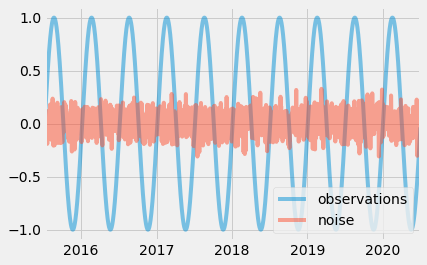

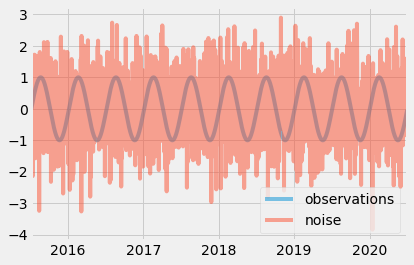

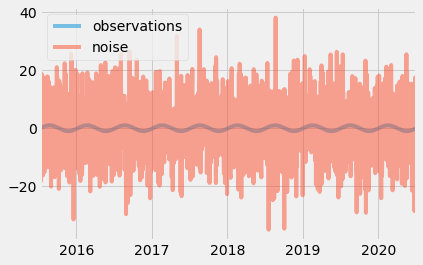

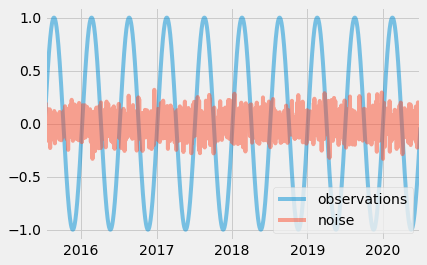

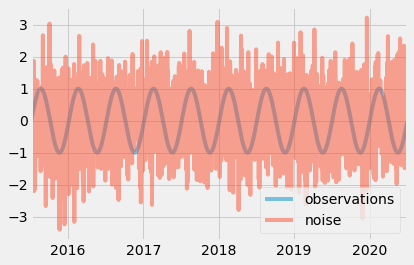

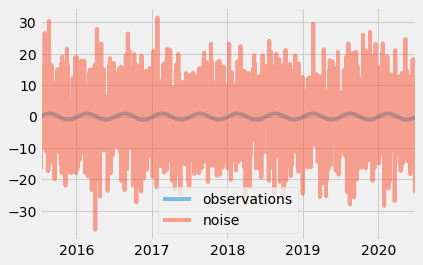

In [3]:
# add random noise with zero mean and varying standard deviation as a separate feature to the input data 
standard_deviations = [0.1, 1.0, 10.0]

# initialize results dictionary
res_2 = {'model_type': [], 'std': [], 'val_mse': []
       , 'mse': [], 'total_training_time': []}

# model type 
model_types = ['RNN', 'LSTM']

for model_type in model_types:
    
    for std in standard_deviations:
        
        # generate Gaussian noise
        mean = 0.0
        noise = [np.random.normal(loc=mean, scale=std, size=None) for x in range(len(idx))]

        # initialize dataframe to store time series
        df = pd.DataFrame(data={'observations': observations, 'noise': noise})
        df.index = idx

        # plot clean data and added noise
        df.plot(alpha=0.5)
        # save figure
        fig_name = model_type + '_std_' + str(std) + '.jpg'
        plt.savefig('../images/03_' + fig_name, dpi=500)

        # load dataframe into object
        mdq.df = df

        # initialize dataset from dataframe 
        mdq.initialize_dataset()

        # standardize data
        mdq.standardize_data()

        # generate train and validation data
        mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)

        # set number of steps per epoch
        num_samples = mdq._num_samples
        steps_per_epoch = int(num_samples/future_target_size)
        validation_steps = int(steps_per_epoch/2)

        # compile model
        mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

        # fit model
        mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
                      ,validation_steps=validation_steps, model_type=model_type)

        # get errors
        history = mdq._histories[model_type]
        val_mse = history.history['val_mse'][-1]
        mse = history.history['mse'][-1]

        # get total training time
        total_training_time = sum(mdq._time_callbacks[model_type].times)

        # append results to results dictionary
        res_2['model_type'].append(model_type)
        res_2['std'].append(std)
        res_2['val_mse'].append(val_mse)
        res_2['mse'].append(mse)
        res_2['total_training_time'].append(total_training_time)

<a id='Part2.2_link'></a>
### 2.2 Visualize and save results

In [4]:
# transform dictionary to dataframe
df_res_22 = pd.DataFrame(res_2)

# store dataframe as csv locally
df_res_22.to_csv('../data/03_results_addedNoise.csv')

# read in stored data
# df_res_22 = pd.read_csv('../data/03_results_addedNoise.csv')

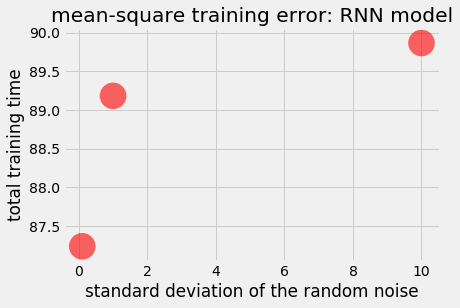

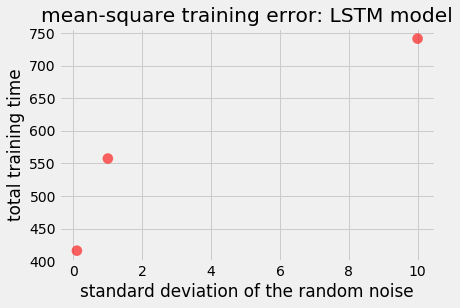

In [5]:
# visualize results; use bubble plots to indicate magnitude of mean-square error for specific configuration comparing
# RNN to LSTM results

df_res = df_res_22

x_label = 'std'
y_label = 'total_training_time'
z_label = 'mse'

for model_type in model_types:
    condition_1 = (df_res['model_type']== model_type)
    
    x = df_res[condition_1][x_label].values
    y = df_res[condition_1][y_label].values
    
    z = df_res[condition_1][z_label].values
    plt.scatter(x, y, s=z*10000, alpha=0.6, c="red", linewidth=0.0)
        
    plt.xlabel('standard deviation of the random noise')
    plt.ylabel('total training time')
    plt.title('mean-square training error: {} model'.format(model_type))
    plt.show()

<a id='Part3_link'></a>
# 3. Distorted time series

Run RNN and LSTM model with noise added ontop of the clean data. Evaluate model performance for a range of variances of the noise.

In [6]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=5*364, freq='d')

# take a sine function as the observations
num_periods = 10  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]

# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# set target feature 
mdq._selected_features = ['observations']


<a id='Part3.1_link'></a>
### 3.1 Evaluate model performance under varying noise levels

In [ ]:
# add random noise with zero mean and varying standard deviation as a separate feature to the input data 
# standard_deviations = [0.1, 1.0, 10.0]

# initialize results dictionary
res_3 = {'model_type': [], 'std': [], 'val_mse': []
       , 'mse': [], 'total_training_time': []}

# model type 
model_types = ['RNN', 'LSTM']

for model_type in model_types:
    
    for std in standard_deviations:
      
        # generate noisy observations by adding Gaussian noise to clean observations
        mean = 0.0
        noise = [np.random.normal(loc=mean, scale=std, size=None) for x in range(len(idx))]        
        noisy_observations = [noise[i]+observations[i] for i in range(len(noise))]
        
        # initialize dataframe to store time series
        df = pd.DataFrame(data={'observations': noisy_observations})
        df.index = idx

        # plot clean data and added noise
        df.plot(alpha=0.5)
        # save figure
        fig_name = model_type + '_std_' + str(std) + '.jpg'
        plt.savefig('../images/03_' + fig_name, dpi=500)

        # load dataframe into object
        mdq.df = df

        # initialize dataset from dataframe 
        mdq.initialize_dataset()

        # standardize data
        mdq.standardize_data()

        # generate train and validation data
        mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)

        # set number of steps per epoch
        num_samples = mdq._num_samples
        steps_per_epoch = int(num_samples/future_target_size)
        validation_steps = int(steps_per_epoch/2)

        # compile model
        mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

        # fit model
        mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
                      ,validation_steps=validation_steps, model_type=model_type)

        # get errors
        history = mdq._histories[model_type]
        val_mse = history.history['val_mse'][-1]
        mse = history.history['mse'][-1]

        # get total training time
        total_training_time = sum(mdq._time_callbacks[model_type].times)

        # append results to results dictionary
        res_3['model_type'].append(model_type)
        res_3['std'].append(std)
        res_3['val_mse'].append(val_mse)
        res_3['mse'].append(mse)
        res_3['total_training_time'].append(total_training_time)

training set shape: x:(909, 365, 1), y:(909, 7, 1)
validation set shape: x:(174, 365, 1), y:(174, 7, 1)
Epoch 1/10
129/129 [==============================] - 15s 114ms/step - loss: 0.1042 - mse: 0.1042 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 2/10
129/129 [==============================] - 15s 116ms/step - loss: 0.0646 - mse: 0.0646 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 3/10
129/129 [==============================] - 15s 114ms/step - loss: 0.0564 - mse: 0.0564 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 4/10
129/129 [==============================] - 15s 118ms/step - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0509 - val_mse: 0.0509
Epoch 5/10
129/129 [==============================] - 15s 116ms/step - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 6/10
129/129 [==============================] - 15s 115ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 7/10
129/129 [==============================] - 15s 115ms/step - loss: 0.0433 - 

<a id='Part3.2_link'></a>
### 3.2 Visualize and save results

In [ ]:
# transform dictionary to dataframe
df_res_32 = pd.DataFrame(res_3)

# store dataframe as csv locally
df_res_32.to_csv('../data/03_results_distored.csv')

# read in locally stored data
# df_res_32 = pd.read_csv('../data/03_results_distored.csv')

In [ ]:
# visualize results; use bubble plots to indicate magnitude of mean-square error for specific configuration comparing
# RNN to LSTM results

df_res = df_res_32

x_label = 'std'
y_label = 'total_training_time'
z_label = 'mse'

for model_type in model_types:
    condition_1 = (df_res['model_type']== model_type)
    
    x = df_res[condition_1][x_label].values
    y = df_res[condition_1][y_label].values
    
    z = df_res[condition_1][z_label].values
    plt.scatter(x, y, s=z*10000, alpha=0.6, c="red", linewidth=0.0)
        
    plt.xlabel('standard deviation of the random noise')
    plt.ylabel('total training time')
    plt.title('mean-square training error: {} model'.format(model_type))
    plt.show()